# Quick Start

-----
<a id='top'></a>

## Content

<div style="height:10px;"></div>

- [// Why Bayesian Principal Component Analysis?](#why)
- [// Creating Synthetic data](#synth)
- [// Setting up the data/model](#setup)
- [// Exp1: Running the model](#running)
- [// Model diagnostics](#diagnostics)
- [// Plotting and Visualization](#plotting-and-visualization)
- [// Exp2: Omitting individual stations](#exp_running)
- [// References](#References)

-----

<a id='why'></a>
### Why Bayesian Principal Component Analysis?

BPCA can be used to estimate the principal components for discontinuous/incomplete data. A full empirical probability distribution of the parameters is estimated [2], in contrast to maximum likelihood estimation or traditional PCA [3].


#### Model definition

We estimate height changes $\mathbf{U}(\mathbf{x},\mathbf{t})$ at every station in space $\mathbf{x}$ and time $\mathbf{t}$ as described by the following model: 

\begin{equation*}
 \mathbf{U}(\mathbf{x},\mathbf{t}) =  \mathbf{g}(\mathbf{x})\mathbf{t} + \sum_{k=1}^{k_{n}} \mathbf{W_k}(\mathbf{x}) \mathbf{p_k}(\mathbf{t})  + \mathbf{\epsilon}(\mathbf{x})\label{eq1}
\end{equation*}

Here, $\mathbf{p_k}(\mathbf{t})$ are $\mathbf{t}$-dimensional latent variables, or principal components, which are mapped onto the observations by the transformation matrix $\mathbf{W_k}(\mathbf{x})$. $\mathbf{W_k}(\mathbf{x})$ represent the spatial pattern of the common modes of variability (i.e., the EOF pattern) while the principal components $\mathbf{p_k}\mathbf{t})$ modulate the evolution of these pattern in time. The $\mathbf{x}$-dimensional vector $\mathbf{g}$ accounts for constant linear trends in the time series; $\mathbf{\epsilon}(\mathbf{x})$ describes technique-dependent Gaussian noise. 

For each parameter we define prior distributions. We assign Gaussian distributions to $\mathbf{g}$ and $\mathbf{W_k}(\mathbf{x})$, and a halfnormal distribution for the estimated variance $\mathbf{\epsilon}(\mathbf{x})$:

\begin{equation*}
  P(\mathbf{g}) \sim \mathcal{N}(\mathbf{\mu_{g}},\,\mathbf{\sigma_g^{2}})\label{eq2} \\
\end{equation*}
\begin{equation*}
  P(\mathbf{W}) \sim \mathcal{N}(\mathbf{\mu_{W}},\,\mathbf{\sigma_W^{2}})\label{eq3} \\
\end{equation*}
\begin{equation*}
  P(\mathbf{\epsilon}) \sim Halfnormal(\mathbf{\sigma_\epsilon^{2}})\label{eq4} \\
\end{equation*}

The technique-dependent variance $\mathbf{\epsilon}(\mathbf{x})$ is estimated individually for the two different techniques (GNSS and SATTG), considering that noise amplitudes differ by one order of magnitude. The principal components are modelled as Gaussian Random Walks, to simulate smoothly varying behaviour of the VLM. With this constrain we avoid that spurious high frequency signals are absorbed by the PCs:

\begin{equation*}
  \mathbf{p_k}(\mathbf{t}) = \mathbf{p_k}(\mathbf{t}-1) + \mathbf{h_k}(\mathbf{t}), P(\mathbf{h_k}) \sim \mathcal{N}(\mathbf{\mu_{h_k}},\mathbf{\sigma_{h_k}^2})
\end{equation*}

#### Model fitting

The model parameter are simultaneously estimated within a Bayesian Framework. The model implementation, the distribution setups and the sampling algorithms are all based on PyMC3, an extensive python-library to setup Bayesian models (see https://docs.pymc.io/). More information on the exact implementation is given in the paper.

[back to top ](#top)

----
## Creating synthetic data
<a id='synth'></a>
We create here synthetic data that mimic two classes of observations, GPS and differences of altimetry and tide gauge data. Here, GPS data has lower noise than the tide gauge data.

In [1380]:
from bpca.utils import *
from bpca.bpca_plots import *

my_cmap = cmap('BlueWhiteOrangeRed_c')

random_seed = 100
random.seed(random_seed)
np.random.seed(random_seed)

# all units are in mm here

synthetic_data_settings={'number_gnss': 500,
                            'number_sattg' : 30,
                            'sigma_gnss' : 5,
                            'sigma_sattg' : 15,
                            'std_deviation_trends' : 0.5,
                            'std_deviation_pcs' : 0.5,
                            'max_lev' : 20,
                            'time_series_length':26,
                            'miss_gnss_factor':20,
                            'miss_sattg_factor':2,
                            'miss_data_background_factor':5,
                            'random_seed':random_seed,
                            'relaxation_coeff':1}

data_set_synt,coastline = create_synthetic_data(**synthetic_data_settings)

This function creates some trend $\mathbf{\hat{g(x)}}$ and eof pattern $\mathbf{\hat{W(x)}}$, which are perturbed by normally distributed perturbations to obtain the trends $\mathbf{g(x)}$ and eof pattern $\mathbf{W(x)}$, which will present the input observations to the model.

In [14]:
data_set_synt

<xarray.Dataset>
Dimensions:             (time: 26, x: 530)
Coordinates:
    lon                 (x) float64 2.13 8.218 6.741 18.46 ... 14.69 7.39 16.16
    lat                 (x) float64 10.87 5.567 8.49 ... 8.696 11.68 8.096
    ID                  (x) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
  * time                (time) datetime64[ns] 1995-12-31 ... 2020-12-31
Dimensions without coordinates: x
Data variables:
    data                (time, x) float64 5.368 8.306 41.04 ... 17.89 7.989
    data_with_noise     (time, x) float64 12.01 3.411 31.81 ... -31.21 -27.83
    trend               (x) float64 0.6127 0.2164 0.2775 ... -0.04241 -0.963
    trend_with_noise    (x) float64 0.6757 -0.1703 -0.5353 ... 0.13 -1.343
    eof                 (x) float64 -2.556 -0.4312 -4.757 ... 4.082 3.761 3.804
    eof_with_noise      (x) float64 -2.627 -0.7315 -4.453 ... 4.07 3.64 3.414
    pc_timeseries       (time) float64 -6.931 -6.931 -6.931 ... 3.365 4.055 4.7
    time_series         (time) float64 0.0 1.0 2.0 3.0 ... 22.0 23.0 24.0 25.0
    missing_data_gps    (time) float64 0.3 0.2341 0.1899 0.1602 ... 0.1 0.1 0.1
    missing_data_sattg  (time) float64 0.12 0.1181 0.1164 ... 0.1018 0.1016

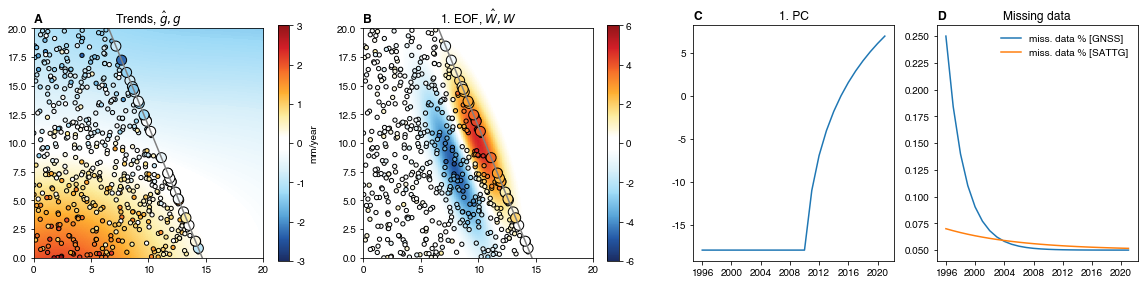

In [1231]:
plot_synthetic_data_maps(data_set_synt,synthetic_data_settings,coastline)

[back to top ](#top)

-----
## Setting up the data/model
<a id='setup'></a>

To set up the model import the bpca class and the standard model settings and have a look into the model settings. 

In [1264]:
from bpca.bpca import bpca as bpca
from bpca.model_settings import set_settings
import xarray as xr

In [1294]:
settings = set_settings()
settings

{'model_settings': {'number_of_pcs': 3,
  'model_trend': True,
  'sigma_random_walk': 0.001,
  'estimate_point_variance': False,
  'estimate_cluster_sigma': False,
  'trend_pattern': None,
  'initialize_trend_pattern': False,
  'estimate_offsets': False,
  'trend_factor_sigma': 0.01,
  'trend_factor_nu': 2.1,
  'trend_distr': 'normal',
  'cluster_index': None,
  'sigma': 0.4,
  'sigma_offset': 0.1,
  'sigma_eofs': 0.15,
  'sigma_random_walk_factor': 0.04},
 'run_settings': {'n_samples': 4000,
  'compress': True,
  'sample_settings': {'tune': 2000,
   'cores': 4,
   'target_accept': 0.9,
   'return_inferencedata': True}},
 'normalization_settings': {}}

The dictionary contains information required for the priors ('model_settings'), the sampling ('run_settings'), as well as some information for data-normalization ('normalization_settings'). 

### Settings
Description of different seetings to choose from:
#### Model settings
* 'number_of_pcs': Number of maximum PCs to use
* 'model_trend': Estimate trend (or not)
* 'sigma_random_walk': standard deviation of gaussian random walk innovations (of PCs)
* 'estimate_point_variance': Estimate variance (i.e. white noise) for every station
* 'estimate_cluster_sigma': Estimate variance (i.e. white noise) for different cluster
* 'estimate_offsets': Estimate offsets for every station (or not)
* 'estimate_sigma_eof': Estimate hierarchical sigma for eof pattern
* 'trend_pattern': Initialize trends with np.array() of size space_dim
* 'initialize_trend_pattern': Initialize trend (or not)
* 'trend_factor_sigma': Prior stddev: trends
* 'trend_factor_nu': Prior shape factor for studen't distr.: trends
* 'trend_distr': Apply 'students_t' or 'normal' distribution for trends
* 'cluster_index': Define different clusters for which different variances are computed. Use np.array, with cluster indices (0,1,2, ...)
* 'sigma': Prior stddev: sigma, float or np.array
* 'sigma_offset': Prior stddev: offsets, float or np.array
* 'sigma_eofs': Prior stddev: EOFs, float or np.array
* 'sigma_random_walk_factor': factor by which sigma_random_walk is divided for subsequent PCs,
    sets some prior contraints, such thus the first EOFs capture most of the variance.
    e.g. if sigma_random_walk_factor is 2 and sigma_random_walk is 2,
    then sigma_random_walk(PC1) = 2; sigma_random_walk(PC2) = 1; sigma_random_walk(PC3) = 0.5 ...

#### Run settings

(https://docs.pymc.io/api/inference.html)

*  'n_samples': number of samples
*  'adjust_pca_symmetry' : match pcs from different chains (tbd before compress)
*  'check_convergence' : compute convergence statistics (e.g., rhat, ess) (tbd before compress)
*  'compress': compress chain (compute mean and std of all variables)

#### Sampling settings

*   'tune': 2000, number of tuning steps
*   'cores': 4, number of chains
*   'target_accept': 0.9, acceptance rate
*   'return_inferencedata': True

Control the number of cores ('cores') used or the number of sampling iterations ('n_samples'). You can also control settings of the NUTS sampler (https://docs.pymc.io/api/inference.html)

#### Model initialization

In [1295]:
name='test_bpca_model'
settings['model_settings']['number_of_pcs']=1
settings['model_settings']['trend_factor_sigma']=0.001
settings['model_settings']['sigma']=0.003

settings['model_settings']['trend_distr']='normal'
settings['model_settings']['sigma_random_walk']=0.001
settings['model_settings']['sigma']=0.4
settings['model_settings']['sigma_random_walk_factor']=0.04
settings['model_settings']['sigma_eofs']=1.15

[back to top ](#top)

-----
## Exp1: Running the model
<a id='running'></a>

Now run the model. Here we set only 2 chains and 500 iterations. As shown in the main text, different variance parameters are estimated for different techniques, because GNSS VLM data is much more precise than the ones derived from 'SAT minus TG'. We estimate different white noise parameter for the different cluster:

In [1296]:
settings['model_settings']['cluster_index'] = data_set_synt['ID'].values
settings['model_settings']['estimate_cluster_sigma']=True
settings['model_settings']['estimate_sigma_eof']=True
settings['model_settings']['estimate_point_variance']=True
settings['run_settings']['n_samples'] =1500
settings['run_settings']['compress'] =False
settings['run_settings']['sample_settings'] ={'tune': 2000,
                                                  'cores': 2,
                                                  'target_accept': 0.9,
                                                  'return_inferencedata': True}
settings['run_settings']['check_convergence'] =False
settings['run_settings']['adjust_pca_symmetry'] =False

Initialize the model

In [660]:
bpca_object = bpca(data_set_synt['data_with_noise']/1000.,run_settings=settings['run_settings'],
                  model_settings = settings['model_settings'],name=name)

estimate different sigma for different clusters


/home/oelsmann/.conda/envs/vlad_py37/lib/python3.6/site-packages/pymc3/model.py:1668: ImputationWarning: Data in Observations contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [661]:
bpca_object.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observations_missing, trend_g, W0, PC0, sigma_hier, sigma_eof]


Sampling 2 chains for 2_000 tune and 500 draw iterations (4_000 + 1_000 draws total) took 151 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[back to top ](#top)

-----
## Model output and diagnostics
<a id='output'></a>


The output can be accessed here:

In [114]:
bpca_object.trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [1393]:
bpca_object.trace.posterior

<xarray.Dataset>
Dimensions:                     (Estimates_dim_0: 26, Estimates_dim_1: 530, Observations_missing_dim_0: 934, PC0_dim_0: 26, W0_dim_0: 530, chain: 2, draw: 1500, sigma_dim_0: 530, sigma_eof_dim_0: 1, sigma_hier_dim_0: 2, trend_g_dim_0: 530)
Coordinates:
  * chain                       (chain) int64 0 1
  * draw                        (draw) int64 0 1 2 3 4 ... 1496 1497 1498 1499
  * PC0_dim_0                   (PC0_dim_0) int64 0 1 2 3 4 5 ... 21 22 23 24 25
  * W0_dim_0                    (W0_dim_0) int64 0 1 2 3 4 ... 526 527 528 529
  * trend_g_dim_0               (trend_g_dim_0) int64 0 1 2 3 ... 527 528 529
  * Observations_missing_dim_0  (Observations_missing_dim_0) int64 0 1 ... 933
  * sigma_eof_dim_0             (sigma_eof_dim_0) int64 0
  * sigma_hier_dim_0            (sigma_hier_dim_0) int64 0 1
  * sigma_dim_0                 (sigma_dim_0) int64 0 1 2 3 ... 526 527 528 529
  * Estimates_dim_0             (Estimates_dim_0) int64 0 1 2 3 ... 22 23 24 25
  * Estimates_dim_1             (Estimates_dim_1) int64 0 1 2 3 ... 527 528 529
Data variables:
    PC0                         (chain, draw, PC0_dim_0) float64 -0.02674 ......
    W0                          (chain, draw, W0_dim_0) float64 -1.264 ... 0.14
    trend_g                     (chain, draw, trend_g_dim_0) float64 0.000873...
    Observations_missing        (chain, draw, Observations_missing_dim_0) float64 ...
    sigma_eof                   (chain, draw, sigma_eof_dim_0) float64 0.9998...
    sigma_hier                  (chain, draw, sigma_hier_dim_0) float64 0.004...
    sigma                       (chain, draw, sigma_dim_0) float64 0.00495 .....
    Estimates                   (chain, draw, Estimates_dim_0, Estimates_dim_1) float64 ...
Attributes:
    created_at:                 2023-09-11T13:31:37.588499
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              203.96838188171387
    tuning_steps:               2000

Since we run different independent chains, and the principal components might be subject to label switching and symmetry, we manually match the PCs of the individual chains with the following function (see also discussion here: https://discourse.pymc.io/t/unique-solution-for-probabilistic-pca/1324/2):

In [640]:
bpca_object.adjust_pca_symmetry()
# Note sigma_eof is not sorted here

replaced variable PC0 (chain 0 ) with variable PC0 (chain 0)
replaced variable PC0 (chain 1 ) with variable PC0 (chain 1)
replaced variable W0 (chain 0 ) with variable W0 (chain 0)
replaced variable W0 (chain 1 ) with variable W0 (chain 1)
replaced variable sigma_eof0 (chain 0 ) with variable sigma_eof0 (chain 0)
replaced variable sigma_eof0 (chain 1 ) with variable sigma_eof0 (chain 1)


Now check the convergence statistics (representing the mean statistics)

In [1391]:
bpca_object.check_convergence()
bpca_object.convergence_stats

,PC0,W0,trend_g,sigma
r_hat,1.040000,1.005962,1.000000,1.000094
ess_mean,0.066564,0.709587,1.826898,2.041592


Check some of the markov chains (here PC0 is shown for every time step):

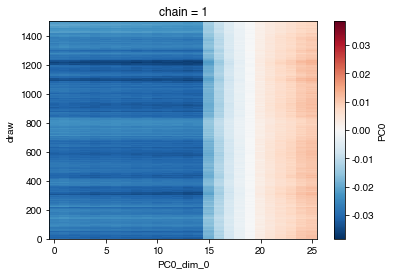

In [1394]:
bpca_object.trace.posterior['PC0'][1,:,:].plot()

Finally we can compress the trace

In [1396]:
bpca_object.compress()

successfully compressed trace


... which returns a dictionary with mean and std estimates of the trace (removing the draw dimension)

In [130]:
bpca_object.trace

{'mean': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats,
 'std': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats}

After compressing the markov chains, for every the mean and standard-deviations of the parameters are provided.

In [131]:
bpca_object.trace['mean'].posterior

<xarray.Dataset>
Dimensions:                     (Estimates_dim_0: 26, Estimates_dim_1: 530, Observations_missing_dim_0: 1574, PC0_dim_0: 26, W0_dim_0: 530, chain: 2, sigma_dim_0: 530, sigma_eof_dim_0: 1, sigma_hier_dim_0: 2, trend_g_dim_0: 530)
Coordinates:
  * chain                       (chain) int64 0 1
  * PC0_dim_0                   (PC0_dim_0) int64 0 1 2 3 4 5 ... 21 22 23 24 25
  * W0_dim_0                    (W0_dim_0) int64 0 1 2 3 4 ... 526 527 528 529
  * trend_g_dim_0               (trend_g_dim_0) int64 0 1 2 3 ... 527 528 529
  * Observations_missing_dim_0  (Observations_missing_dim_0) int64 0 1 ... 1573
  * sigma_eof_dim_0             (sigma_eof_dim_0) int64 0
  * sigma_hier_dim_0            (sigma_hier_dim_0) int64 0 1
  * sigma_dim_0                 (sigma_dim_0) int64 0 1 2 3 ... 526 527 528 529
  * Estimates_dim_0             (Estimates_dim_0) int64 0 1 2 3 ... 22 23 24 25
  * Estimates_dim_1             (Estimates_dim_1) int64 0 1 2 3 ... 527 528 529
Data variables:
    PC0                         (chain, PC0_dim_0) float64 0.01404 ... -0.00941
    W0                          (chain, W0_dim_0) float64 1.387 ... -0.5798
    trend_g                     (chain, trend_g_dim_0) float64 0.0005844 ... ...
    Observations_missing        (chain, Observations_missing_dim_0) float64 0...
    sigma_eof                   (chain, sigma_eof_dim_0) float64 1.336 1.579
    sigma_hier                  (chain, sigma_hier_dim_0) float64 0.004982 .....
    sigma                       (chain, sigma_dim_0) float64 0.004982 ... 0.0...
    Estimates                   (chain, Estimates_dim_0, Estimates_dim_1) float64 ...

Recombine estimated trends and pcs and apply uncertainty propagation:

In [644]:
bpca_object.recombine_datasets()

In [422]:
bpca_object.estimated_dataset

<xarray.Dataset>
Dimensions:              (time: 26, x: 530)
Coordinates:
    lon                  (x) float64 2.13 8.218 6.741 18.46 ... 14.69 7.39 16.16
    lat                  (x) float64 10.87 5.567 8.49 ... 8.696 11.68 8.096
    ID                   (x) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
  * time                 (time) datetime64[ns] 1995-12-31 ... 2020-12-31
Dimensions without coordinates: x
Data variables:
    data_with_noise      (time, x) float64 0.008921 0.008888 ... 0.004385
    data_with_noise_std  (time, x) float64 0.008511 0.007558 ... 0.00741 0.00825
Attributes:
    chain:    0

This property shows how much of the variance of the observed data is explained:

In [645]:
bpca_object.explained_variance.mean()

<xarray.DataArray 'data_with_noise' ()>
array(0.61372726)

Save and load the model as follows:

In [ ]:
bpca_object.save(save_dir = 'bpca/examples/model_name')

In [ ]:
bpca_object = bpca.load(save_dir = 'bpca/examples/model_name')

[back to top ](#top)

## Plotting and Visualization
<a id='plotting-and-visualization'></a>

### Individual time series

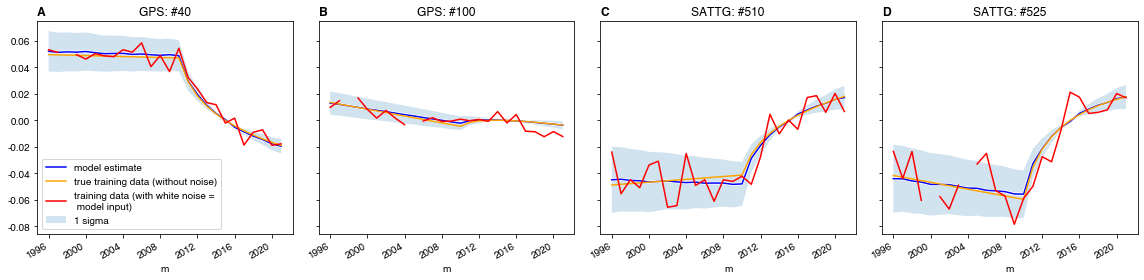

In [1166]:
fig,axs = plt.subplots(1,4,figsize=(16,4),sharey=True)

i=0
for index,title in zip([40,100,510,525],['A','B','C','D']):
    mean_est = bpca_object.estimated_dataset['data_with_noise'][:,index]
    std_est = bpca_object.estimated_dataset['data_with_noise_std'][:,index]
    mean_est.plot(ax=axs[i],color='white',linewidth=3)
    mean_est.plot(ax=axs[i],label='model estimate',color='blue')
    axs[i].fill_between(bpca_object.dataset.time.values, mean_est - std_est, mean_est + std_est, alpha=0.2,label='1 sigma')
    (data_set_synt['data'][:,index]/1000.).plot(ax=axs[i],label='true training data (without noise)',color='orange')
    bpca_object.dataset[:,index].plot(ax=axs[i],label='training data (with white noise =\n model input)',color='red')
    axs[i].set_title(label=title,loc='left',fontweight='bold')
    axs[i].set_title(('GPS' if data_set_synt['ID'][index] == 0 else 'SATTG')+': #'+str(index)) 
    
    axs[i].set_xlabel('m')
    axs[i].set_ylabel('')
    i=i+1
    
axs[0].legend()    
plt.tight_layout()
plt.savefig('time_series_exp1.png',dpi=600,bbox_inches='tight')
plt.savefig('time_series_exp1.pdf',bbox_inches='tight')

Shown are <font color='red'>the actual training data with white noise</font>, <font color='orange'>the training data without white noise</font>, <font color='blue'>the model mean</font> estimate, as well as some random samples from the markov chain and the recomputed uncertainty of the final estimate.

### Spatial estimates 

First compute uncertainties of $\mathbf{g(x)}$ and eof pattern $\mathbf{W(x)}$ analytically.

In [1382]:
data_set_synt = compute_analytical_uncertainties(data_set_synt)

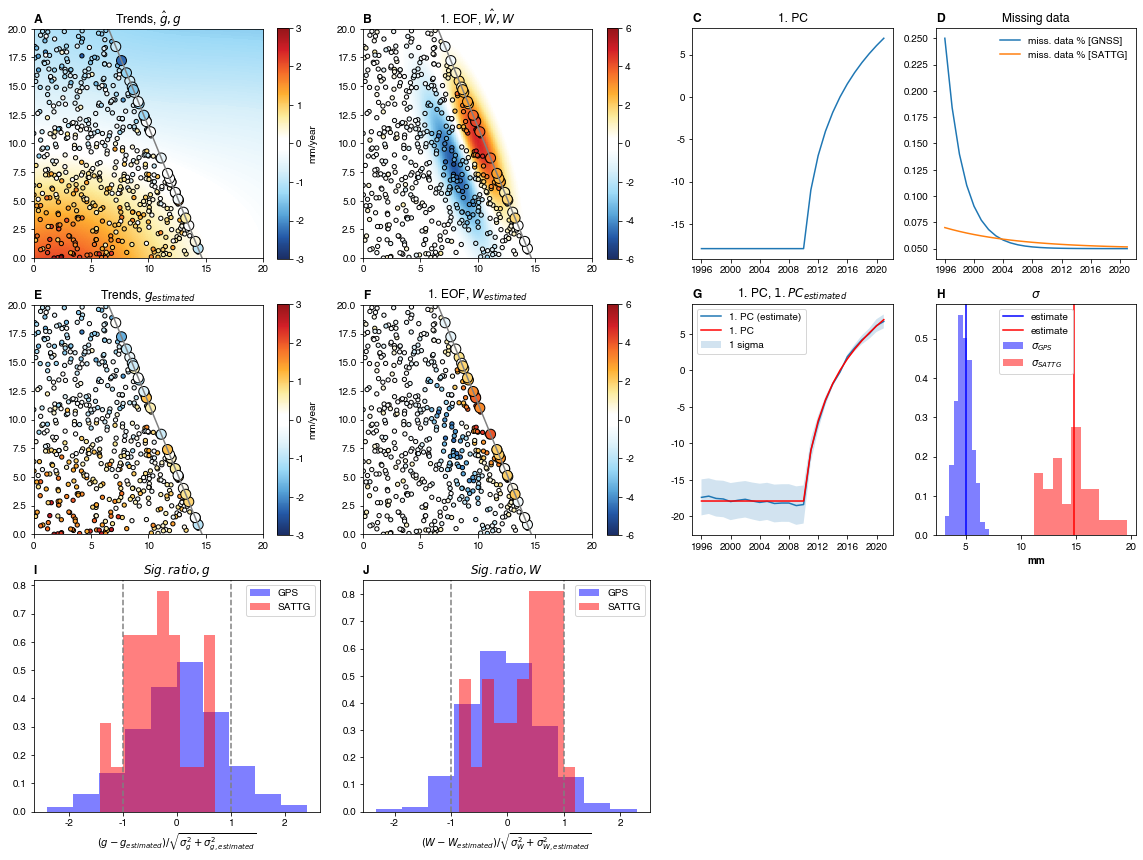

In [1400]:
plot_synthetic_data_maps(data_set_synt,synthetic_data_settings,coastline,
                    validation=True,bpca_object=bpca_object)

As explained in the paper, we interpolate the point estimates using another Bayesian approach, which can be found here: https://github.com/oelsmann/TransTessellate2D. The 2D fields can be loaded into the bpca object to derive the final reconstruction.

These 2D files should be two netcdfs, where one file represents the mean estimate and the other the uncertainty. The data should span the region of interest (with arbitrary resolution). The files should contain the spatial pattern W0, W1, Wx, and the trend pattern (called W99).

In [1416]:
mean_files

<xarray.Dataset>
Dimensions:  (x: 9409)
Coordinates:
    lon      (x) float64 -2.0 -1.75 -1.5 -1.25 -1.0 ... 21.25 21.5 21.75 22.0
    lat      (x) float64 -2.0 -2.0 -2.0 -2.0 -2.0 ... 22.0 22.0 22.0 22.0 22.0
Dimensions without coordinates: x
Data variables:
    W0       (x) float64 0.3387 0.3305 0.3261 0.3225 ... 0.3726 0.3918 0.416
    W99      (x) float64 2.301 2.238 2.187 2.14 ... -1.727 -1.758 -1.794 -1.851

In [1421]:
bpca_object.estimated_dataset_map_pattern=[mean_files,std_files]
bpca_object.recombine_datasets(kind='maps')

Match 2D fields and point locations for validation.

In [1437]:
lon1 = data_set_synt.x.lon.values
lat1 = data_set_synt.x.lat.values

lon2 = bpca_object.estimated_dataset_map_pattern[0].lon.values
lat2 = bpca_object.estimated_dataset_map_pattern[0].lat.values

indices = np.argmin((np.repeat(lon1[:,np.newaxis],len(lon2),axis=1)-np.repeat(lon2[np.newaxis,:],len(lon1),axis=0))**2+(np.repeat(lat1[:,np.newaxis],len(lat2),axis=1)-np.repeat(lat2[np.newaxis,:],len(lat1),axis=0))**2,axis=1)

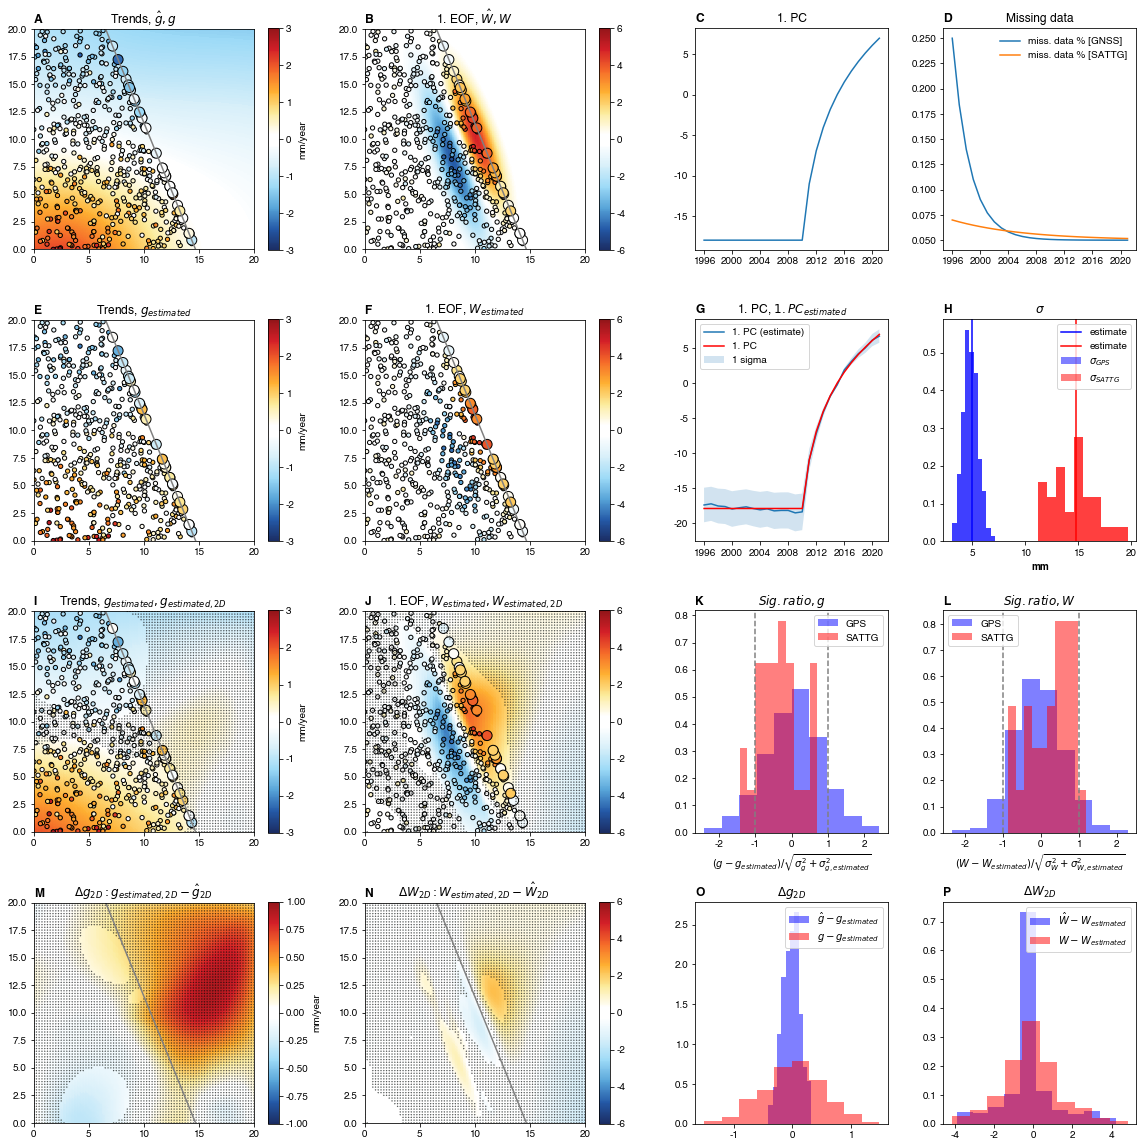

In [1438]:
plot_synthetic_data_maps(data_set_synt,synthetic_data_settings,coastline,
                    validation=True,map_data=True,bpca_object=bpca_objectt,indices=indices)

[back to top ](#top)

----
## Exp2: omitting individual stations
<a id='exp_running'></a>

Omit some stations from the synthetic dataset (note that lon and lat are reversed).

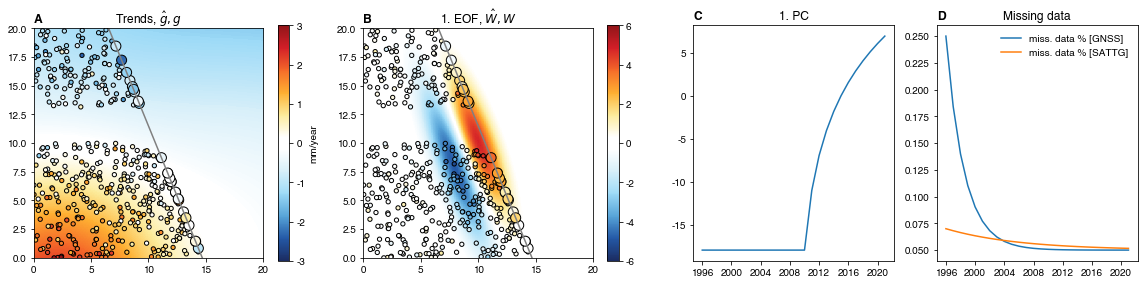

In [1440]:
plot_synthetic_data_maps(data_set_synt.sel({'x':(data_set_synt.lon>13) | (data_set_synt.lon<10)}),synthetic_data_settings,coastline)

In [1117]:
data_set_synt['data_with_noise'].sel({'x':(data_set_synt.lon>13) | (data_set_synt.lon<10)})

<xarray.DataArray 'data_with_noise' (time: 26, x: 458)>
array([[ 23.04892112,  11.32336058,  78.88208563, ..., -12.40985097,
        -69.79189362,  24.67772429],
       [ 16.70985425,  19.95458837,  91.54017576, ..., -20.23500132,
        -65.3776309 ,  14.00354682],
       [ 14.06050529,  19.91578555,          nan, ..., -12.72176553,
        -48.06613667,   7.97603548],
       ...,
       [ -0.55901971,   3.4149369 , -18.624443  , ..., -29.91613046,
          9.59332226,  22.7263143 ],
       [ -5.44058197,  -9.16038391,          nan, ...,  -4.07008733,
         10.99079468,  -7.11781562],
       [ -2.63565213,  -2.19435957, -30.8661067 , ...,  -2.71946949,
         -9.04685145, -23.40893421]])
Coordinates:
    lon      (x) float64 2.13 8.218 6.741 18.46 16.6 ... 18.45 14.69 7.39 16.16
    lat      (x) float64 10.87 5.567 8.49 0.09438 ... 7.161 8.696 11.68 8.096
    ID       (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
  * time     (time) datetime64[ns] 1995-12-31 1996-12-31 ... 2020-12-31
Dimensions without coordinates: x

Rerun the model.

In [1119]:
settings['model_settings']['cluster_index'] = data_set_synt['ID'].sel({'x':(data_set_synt.lon>13) | (data_set_synt.lon<10)}).values

bpca_object_exp2 = bpca(data_set_synt['data_with_noise'].sel({'x':(data_set_synt.lon>13) | (data_set_synt.lon<10)})/1000.,run_settings=settings['run_settings'],
                  model_settings = settings['model_settings'],name=name+'exp2')

estimate different sigma for different clusters


In [1442]:
bpca_object_exp2.run()
bpca_object_exp2.adjust_pca_symmetry()
bpca_object_exp2.check_convergence()
bpca_object_exp2.compress()
bpca_object_exp2.recombine_datasets()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observations_missing, trend_g, W0, PC0, sigma_hier, sigma_eof]


Sampling 2 chains for 2_000 tune and 1_500 draw iterations (4_000 + 3_000 draws total) took 155 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


replaced variable PC0 (chain 0 ) with variable PC0 (chain 0)
replaced variable PC0 (chain 1 ) with variable PC0 (chain 1)
replaced variable W0 (chain 0 ) with variable W0 (chain 0)
replaced variable W0 (chain 1 ) with variable W0 (chain 1)
replaced variable sigma_eof0 (chain 0 ) with variable sigma_eof0 (chain 0)
replaced variable sigma_eof0 (chain 1 ) with variable sigma_eof0 (chain 1)
successfully compressed trace


In [1132]:
bpca_object_exp2.trace['mean'].posterior

<xarray.Dataset>
Dimensions:                     (Estimates_dim_0: 26, Estimates_dim_1: 458, Observations_missing_dim_0: 777, PC0_dim_0: 26, W0_dim_0: 458, chain: 2, sigma_dim_0: 458, sigma_eof_dim_0: 1, sigma_hier_dim_0: 2, trend_g_dim_0: 458)
Coordinates:
  * chain                       (chain) int64 0 1
  * PC0_dim_0                   (PC0_dim_0) int64 0 1 2 3 4 5 ... 21 22 23 24 25
  * W0_dim_0                    (W0_dim_0) int64 0 1 2 3 4 ... 454 455 456 457
  * trend_g_dim_0               (trend_g_dim_0) int64 0 1 2 3 ... 455 456 457
  * Observations_missing_dim_0  (Observations_missing_dim_0) int64 0 1 ... 776
  * sigma_eof_dim_0             (sigma_eof_dim_0) int64 0
  * sigma_hier_dim_0            (sigma_hier_dim_0) int64 0 1
  * sigma_dim_0                 (sigma_dim_0) int64 0 1 2 3 ... 454 455 456 457
  * Estimates_dim_0             (Estimates_dim_0) int64 0 1 2 3 ... 22 23 24 25
  * Estimates_dim_1             (Estimates_dim_1) int64 0 1 2 3 ... 455 456 457
Data variables:
    PC0                         (chain, PC0_dim_0) float64 -0.02552 ... 0.01002
    W0                          (chain, W0_dim_0) float64 -1.233 ... 0.269
    trend_g                     (chain, trend_g_dim_0) float64 0.0006577 ... ...
    Observations_missing        (chain, Observations_missing_dim_0) float64 -...
    sigma_eof                   (chain, sigma_eof_dim_0) float64 1.017 1.017
    sigma_hier                  (chain, sigma_hier_dim_0) float64 0.004969 .....
    sigma                       (chain, sigma_dim_0) float64 0.004969 ... 0.0...
    Estimates                   (chain, Estimates_dim_0, Estimates_dim_1) float64 ...

Recompute 2D fields and add to the dataset.

In [ ]:
bpca_object_exp2.estimated_dataset_map_pattern=[mean_files,std_files]
bpca_object_exp2.recombine_datasets(chain=chain,kind='maps')

In [ ]:
data_set_synt2=data_set_synt.sel({'x':(data_set_synt.lon>13) | (data_set_synt.lon<10)})

lon1 = data_set_synt2.x.lon.values
lat1 = data_set_synt2.x.lat.values

lon2 = bpca_object_exp2.estimated_dataset_map_pattern[0].lon.values
lat2 = bpca_object_exp2.estimated_dataset_map_pattern[0].lat.values
indices2 = np.argmin((np.repeat(lon1[:,np.newaxis],len(lon2),axis=1)-np.repeat(lon2[np.newaxis,:],len(lon1),axis=0))**2+(np.repeat(lat1[:,np.newaxis],len(lat2),axis=1)-np.repeat(lat2[np.newaxis,:],len(lat1),axis=0))**2,axis=1)

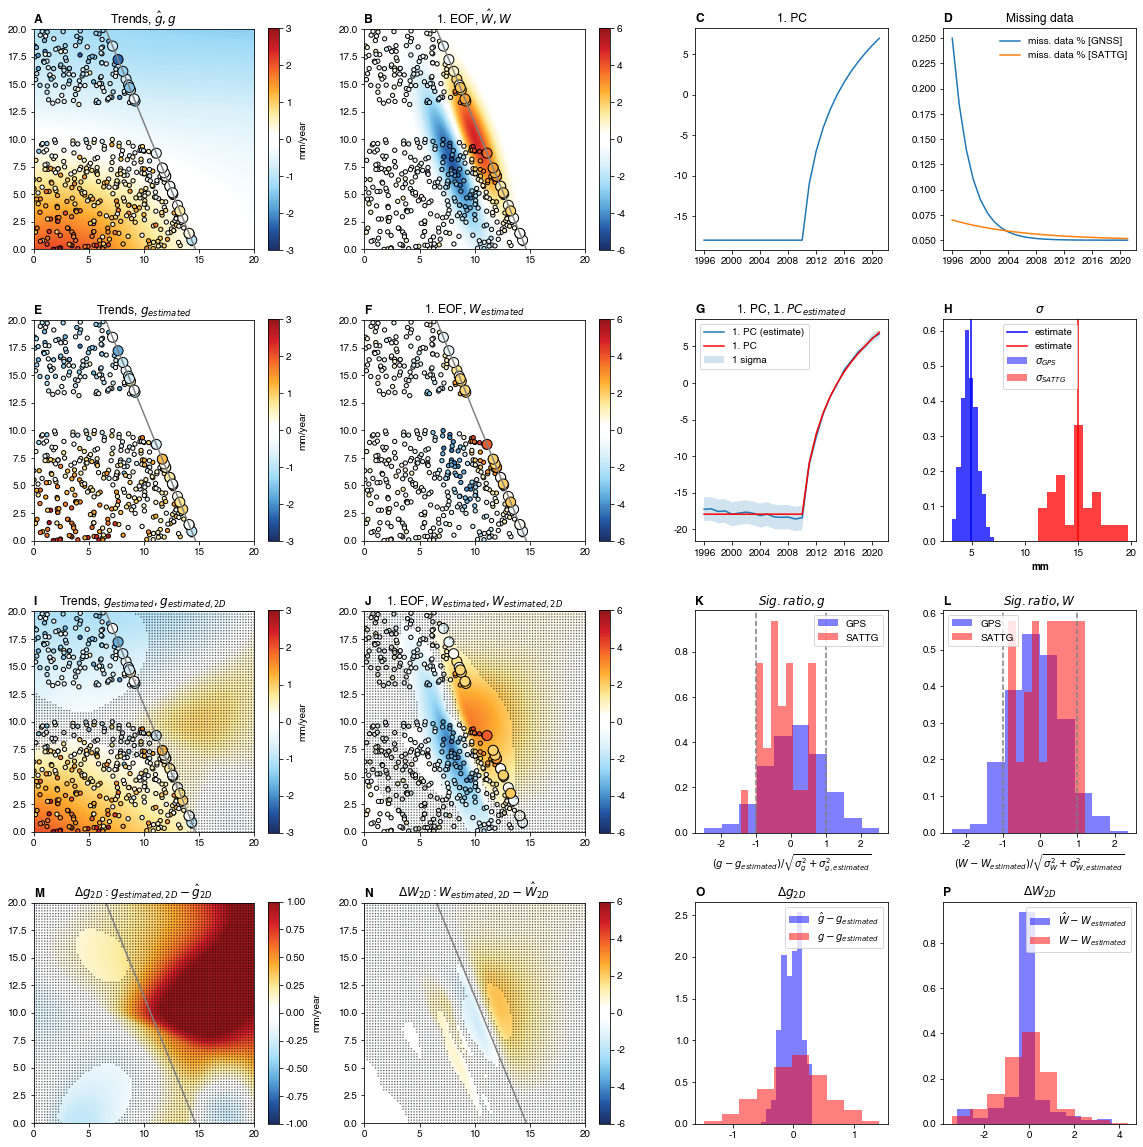

In [1443]:
plot_synthetic_data_maps(data_set_synt2,synthetic_data_settings,coastline,
                    validation=True,bpca_object=bpca_object_exp2,map_data=True,indices=indices2)

[back to top ](#top)
<hr>

## References
<a id='References'></a>


[1] Oelsmann, J., Marcos M., Passaro, M., Sánchez, L., Dettmering D., Dangendorf S., Seitz F. Vertical land motion reconstruction unveils non-linear effects on relative sea level changes from 1900-2150. Nat Geosciences, in review, 2023

[2] Oelsmann, J., Passaro, M., Sánchez, L. et al. Bayesian modelling of piecewise trends and discontinuities to improve the estimation of coastal vertical land motion. J Geod 96, 62 (2022). https://doi.org/10.1007/s00190-022-01645-6

[3] Wudong, L., Jiang, W.-P., Li, Z., Chen, H., Chen, Q., Wang, J., Zhu, G.: Extracting common mode errors of regional gnss position time series in the presence of missing data by variational bayesian principal component analysis. Sensors 20, 2298 (2020). https://doi.org/10.3390/s20082298

[4] Gruszczynski, M., Klos, A., Bogusz, J.: A Filtering of Incomplete GNSS Position Time Series with Probabilistic Principal Component Analysis. Pure and Applied Geophysics 175(5), 1841{1867 (2018). https://doi.org/10.1007/s00024-018-1856-3.


## Data sources

Blewitt G, Kreemer C, Hammond WC, Gazeaux J (2016) Midas robust trend estimator for accurate gps station velocities without step detection. Journal of Geophysical Research: Solid Earth 121(3):2054–2068, DOI 10.1002/2015JB01255    
    
Caron L, Ivins ER, Larour E, Adhikari S, Nilsson J, Blewitt G (2018) Gia model statistics for grace hydrology, cryosphere, and ocean science. Geophysical Research Letters 45(5):2203– 2212, DOI 10.1002/2017GL076644    
    
Frederikse T, Landerer F, Caron L, Adhikari S, Parkes D, Humphrey V, Dangendorf S, Hogarth P, Zanna L, Cheng L, Wu YH (2020) The causes of sea-level rise since 1900. Nature 584:393–397, DOI 10.1038/s41586-020-2591-3
    
Holgate SJ, Matthews A, Woodworth PL, Rickards LJ, Tamisiea ME, Bradshaw E, Fo-den  PR,  Gordon  KM,  Jevrejeva  S,  Pugh  J  (2013)  New  Data  Systems  and  Products at the  Permanent  Service  for  Mean  Sea  Level.  Journal  of  Coastal  Research  pp  493–504,  DOI  10.2112/JCOASTRES-D-12-00175.1,  URLhttps://doi.org/10.2112/JCOASTRES-D-12-00175.1    
    

[back to top ](#top)